# SI 370 - 12.2: Clustering I
## Objectives:
- Be able to perform hierarchical clustering
- Knows how and when to use different similarity functions, including Euclidean, Manhattan, Jaccard, and Cosine.
- Be able to visualize clustering results using dimensionality reduction techniques.


In [2]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# Filter all warnings.
# A recent matplotlib update around October 2015 causes various 
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

## Watch this video for illustration of the Hierarchical Clustering algorithm:
https://www.youtube.com/watch?v=EUQY3hL38cw

# 1. Distance (Similarity) Functions

To explore different distance functions, let us create a toy dataset consisting of people and their personality traits.

Reference: http://ideonomy.mit.edu/essays/traits.html

In [4]:
traits = [
    ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),
    ('Bob', ['Strong', 'Confident', 'Creative','Tidy']),
    ('Charlie', ['Confident', 'Strong', 'Accessible', 'Sweet']),
    ('Dacy', ['Accessible', 'Strong', 'Tidy', 'Confident']),
    ('Emily', ['Reserved', 'Cute', 'Quiet', 'Impassive']),
    ('Fred', ['Cute', 'Impassive', 'Gentle','Confident']),
    ('George', ['Cute', 'Quiet', 'Reserved', 'Confident'])
]

In [5]:
# In order to make computation easier, let's create dummy variables 
# for traits (basically a column for each unique trait and 1 if the
# person has it and 0 if they don't). 
# We're going to walk you through this, but you should be able to do 
# this on your own

In [6]:
# first, let's grab the names for everyone 
names = [x[0] for x in traits]
names

['Alice', 'Bob', 'Charlie', 'Dacy', 'Emily', 'Fred', 'George']

In [7]:
# now, make a dataframe
df_traits = pd.DataFrame(index=names)
df_traits.head()

Empty DataFrame
Columns: []
Index: [Alice, Bob, Charlie, Dacy, Emily]

In [8]:
# next, create some columns
for t in traits:
    person = t[0]
    #print(person," is:")
    ptraits = t[1]  # this person's specific traits
    for pt in ptraits:
        #print("\t",pt)
        df_traits[pt] = 0
df_traits       

Accessible  Confident  Creative  Sweet  Strong  Tidy  Reserved  Cute  \
Alice             0          0         0      0       0     0         0     0   
Bob               0          0         0      0       0     0         0     0   
Charlie           0          0         0      0       0     0         0     0   
Dacy              0          0         0      0       0     0         0     0   
Emily             0          0         0      0       0     0         0     0   
Fred              0          0         0      0       0     0         0     0   
George            0          0         0      0       0     0         0     0   

         Quiet  Impassive  Gentle  
Alice        0          0       0  
Bob          0          0       0  
Charlie      0          0       0  
Dacy         0          0       0  
Emily        0          0       0  
Fred         0          0       0  
George       0          0       0

In [9]:
# finally, let's populate the table
for t in traits:
    person = t[0]
    #print(person," is:")
    ptraits = t[1]  # this person's specific traits
    for pt in ptraits:
        #print("set",person,"'s",pt,"property to 1")
        df_traits.set_value(person,pt,1)  # row,column,value
df_traits

Accessible  Confident  Creative  Sweet  Strong  Tidy  Reserved  Cute  \
Alice             1          1         1      1       0     0         0     0   
Bob               0          1         1      0       1     1         0     0   
Charlie           1          1         0      1       1     0         0     0   
Dacy              1          1         0      0       1     1         0     0   
Emily             0          0         0      0       0     0         1     1   
Fred              0          1         0      0       0     0         0     1   
George            0          1         0      0       0     0         1     1   

         Quiet  Impassive  Gentle  
Alice        0          0       0  
Bob          0          0       0  
Charlie      0          0       0  
Dacy         0          0       0  
Emily        1          1       0  
Fred         0          1       1  
George       1          0       0

In [10]:
# let's see what we have
df_traits

Accessible  Confident  Creative  Sweet  Strong  Tidy  Reserved  Cute  \
Alice             1          1         1      1       0     0         0     0   
Bob               0          1         1      0       1     1         0     0   
Charlie           1          1         0      1       1     0         0     0   
Dacy              1          1         0      0       1     1         0     0   
Emily             0          0         0      0       0     0         1     1   
Fred              0          1         0      0       0     0         0     1   
George            0          1         0      0       0     0         1     1   

         Quiet  Impassive  Gentle  
Alice        0          0       0  
Bob          0          0       0  
Charlie      0          0       0  
Dacy         0          0       0  
Emily        1          1       0  
Fred         0          1       1  
George       1          0       0

### Something to try: Can you make the two cells above more efficient? Hint: what happens if two people have the same trait?

In [11]:
# Let's try different distance measures between Alice and Bob.
# I copied their traits down here:
#    ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),
#    ('Bob', ['Strong', 'Confident', 'Creative','Sporting']),
# Notice they have 4 traits each and they share 2 traits in common.

# (1) Euclidean distance:
# sqrt((1-0)^2 + (1-0)^2 + (0-1)^2+(0-1)^2) = 2
spd.euclidean(df_traits.ix['Alice'],df_traits.ix['Bob'])

2.0

In [12]:
# (2) Jaccard distance:
# 1 - 2/6
spd.jaccard(df_traits.ix['Alice'],df_traits.ix['Bob'])

0.66666666666666663

In [13]:
# (3) Manhattan (cityblock) distance:
# 1 + 1 + 1 + 1
spd.cityblock(df_traits.ix['Alice'],df_traits.ix['Bob'])

4

In [14]:
# (4) Cosine distance
# 1 - 2/(2*2)
spd.cosine(df_traits.ix['Alice'],df_traits.ix['Bob'])

0.5

__Question__: do you know when to use each of the distance measurements? What are the "traits" of each distance measure? Discuss this with your lab partner/group.

In [15]:
# As we have seen in Section 1, you can compute pairwise distance like
# below, using any of the distance measurements. 
dist_traits = spd.squareform(spd.pdist(df_traits,'cosine'))
dist_traits[:4,:4]  # to save space, only show the top left 4x4 block

array([[ 0.  ,  0.5 ,  0.25,  0.5 ],
       [ 0.5 ,  0.  ,  0.5 ,  0.25],
       [ 0.25,  0.5 ,  0.  ,  0.25],
       [ 0.5 ,  0.25,  0.25,  0.  ]])

# Exercise:
1. Compute the Euclidean distance between Charlie and Dacy.
2. Compute the Jaccard distance between Emily and Fred.
3. Compute the Manhattan (cityblock) distance between Alice and Dacy.
4. Compute the Cosine distance between Fred and George.

## 2. Hierarchical Clustering

Let's start with a toy dataset that has two dimensions. There are three obvious clusters.

Reference: https://github.com/herrfz/dataanalysis

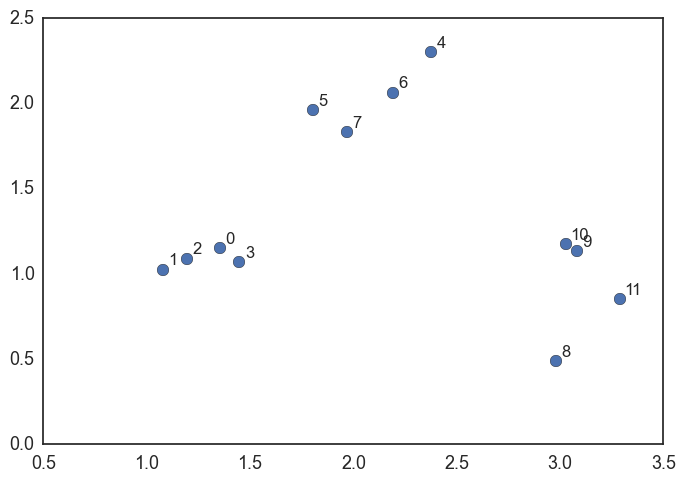

In [16]:
np.random.seed(0)
x = np.random.randn(12) * 0.2 + np.repeat(np.arange(3)+1, 4)
y = np.random.randn(12) * 0.2 + np.repeat(np.array([1,2,1]), 4)
plt.scatter(x, y, s=70)
for i, xi in enumerate(x):
    plt.annotate(str(i), (xi+0.03, y[i]+0.03), fontsize=12)

In [17]:
# Let's create a DataFrame.
df_xy = pd.DataFrame({'x':x,'y':y})
df_xy

x         y
0   1.352810  1.152208
1   1.080031  1.024335
2   1.195748  1.088773
3   1.448179  1.066735
4   2.373512  2.298816
5   1.804544  1.958968
6   2.190018  2.062614
7   1.969729  1.829181
8   2.979356  0.489402
9   3.082120  1.130724
10  3.028809  1.172887
11  3.290855  0.851567

In [18]:
# To perform hierarchical clustering, the first step is to compute 
# the distance matrix. We will be using the Euclidean distance.
dist_xy = spd.squareform(spd.pdist(df_xy,metric='euclidean'))
dist_xy.shape

(12, 12)

In [19]:
# The matrix may be too large to display. So let's display a top-left
# portion of it.
dist_xy[:4,:4]

array([[ 0.        ,  0.30126365,  0.16938929,  0.12806509],
       [ 0.30126365,  0.        ,  0.13244787,  0.37058077],
       [ 0.16938929,  0.13244787,  0.        ,  0.25339119],
       [ 0.12806509,  0.37058077,  0.25339119,  0.        ]])

Notice that in the matrix above, the diagnonal values are 0, which is
expected: an object's distance to itself must be 0.

Before performing hierarchical clustering, let us review an important concept, "linkage function."
 - For hierarchical clustering, a _linkage function_ is a distance function between two clusters. In scipy multiple different linkage functions are implemented, including single, complete, average, weighted, centroid, median, and ward. We will be using "single", which is taking the distance between two nearest points as the distance between two clusters. This is the default option. See [scipy documentation](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.cluster.hierarchy.linkage.html) for more details.

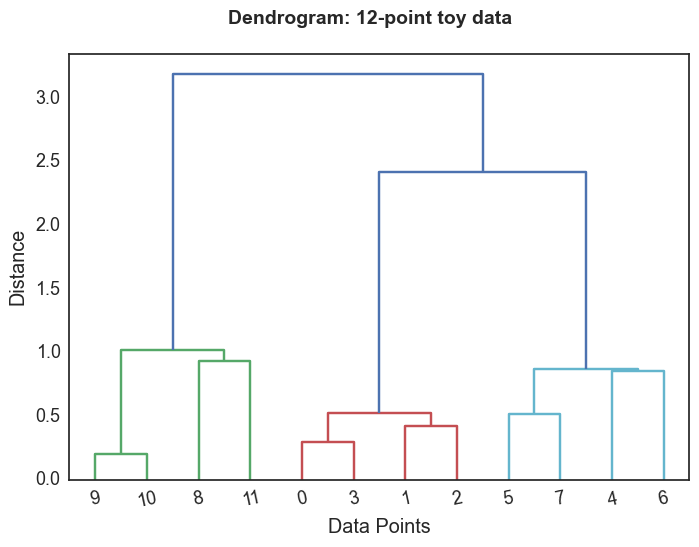

In [20]:
# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(dist_xy,method='single')
_ = sph.dendrogram(Z_xy)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In the above dendrogram, the y-axis depicts the distance at which a cluster is formed. This distance is obtained by evaluating the linkage function. We can see that the green cluster forms at around 1.0, then the next cluster forms at around 2.4. There is a large gap (on the y-axis) in between, which indicates that segmenting the data there may be a good choice. In fact, the scipy package automatically selects a threshold, below which the clusters are colored differently, and above which the clusters are all colored blue. This happens to match our interpretation.

Based on the above analysis, 2.0 seems to be a good distance threshold to "clip" the dendrogram and obtain our clustering results. The way to apply the clipping threshold is as follows:

In [21]:
cluster_labels = sph.fcluster(Z_xy,1.5,criterion='distance')
df_xy['cluster_label'] = cluster_labels
df_xy

x         y  cluster_label
0   1.352810  1.152208              2
1   1.080031  1.024335              2
2   1.195748  1.088773              2
3   1.448179  1.066735              2
4   2.373512  2.298816              3
5   1.804544  1.958968              3
6   2.190018  2.062614              3
7   1.969729  1.829181              3
8   2.979356  0.489402              1
9   3.082120  1.130724              1
10  3.028809  1.172887              1
11  3.290855  0.851567              1

Compare the cluster_labels with the scatterplot at the beginning, we can see that hierarchical clustering indeed captures the actual clusters as expected.

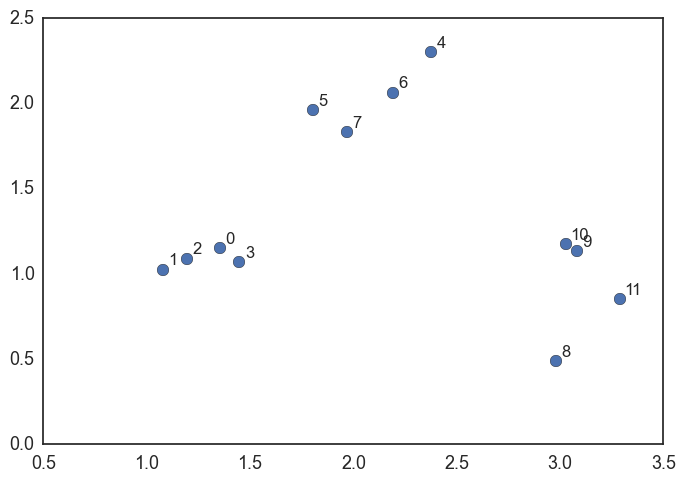

In [22]:
plt.scatter(x, y, s=70)
for i, xi in enumerate(x):
    plt.annotate(str(i), (xi+0.03, y[i]+0.03), fontsize=12)

Now it is your turn. Do the following exercise.

## Fun Activity: Clustering of 370 Class based on Music Tastes

Enter your music tastes in this Google Sheet (scale: 1-10):
https://docs.google.com/a/umich.edu/spreadsheets/d/1XATQzuNiGlTyxTVtWFrhT_5ECJLTvK-l8qeyJwH_liw/edit?usp=sharing


In [57]:
music = pd.read_excel("Clustering of 370 Student.xlsx")
music.head()

Jazz  Soul  Pop  R&B  Opera  Country  Rock&Roll
Kai       8     8   10   10      2        5          6
Chris     4     6    2    7      8        9         10
Kai       8     8   10   10      2        5          6
Chris     4     6    2    7      8        9         10
Kai       8     8   10   10      2        5          6

In [30]:
# To perform hierarchical clustering, the first step is to compute 
# the distance matrix. We will be using the Euclidean distance.
dist_xy = spd.squareform(spd.pdist(music,metric='euclidean'))
dist_xy.shape

(2, 2)

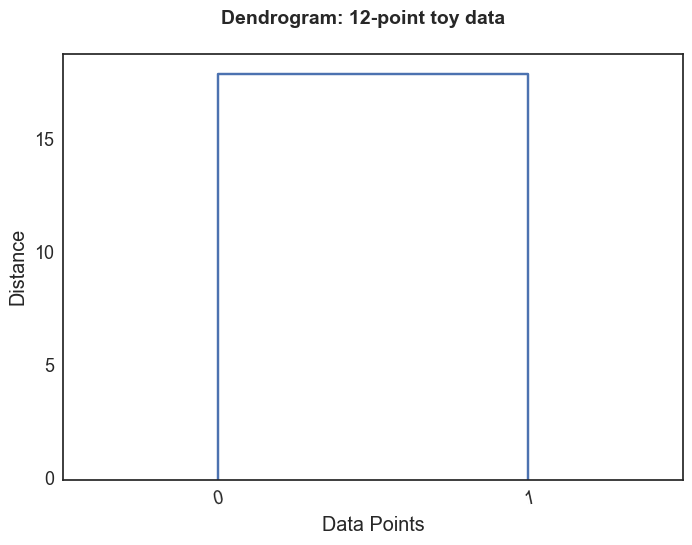

In [31]:
# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(dist_xy,method='single')
_ = sph.dendrogram(Z_xy)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In [35]:
cluster_labels = sph.fcluster(Z_xy,1.5,criterion='distance')
music['cluster_label'] = cluster_labels
music

Jazz  Soul  Pop  R&B  Opera  Country  Rock&Roll  cluster_label
Kai       8     8   10   10      2        5          6              1
Chris     4     6    2    7      8        9         10              2

## Take Home exercises: now perform PCA or Factor Analysis on the music dataset

### Exercise:
- Step 1: __(Code Provided)__ Import the Iris dataset and create a scatterplot, showing petal_lengths and petal_widths.
- Step 2: __(Code Provided)__ Compute the distance matrix among irises using petal_lengths and petal_widths. Use Euclidean distance.
- Step 3: Perform hierarchical clustering.
- Step 4: Pick a distance threshold that can result in 3 clusters so as to match the number of species.
- Step 5: Create a new scatterplot using the cluster labels as hue. Compare it with the original scatterplot.
- Step 6: Create a pivot table to compare actual species and labeled clusters. The rows (index) should be the true species, and the columns should be the cluster labels. The cells are counts. This is also called a confusion matrix.

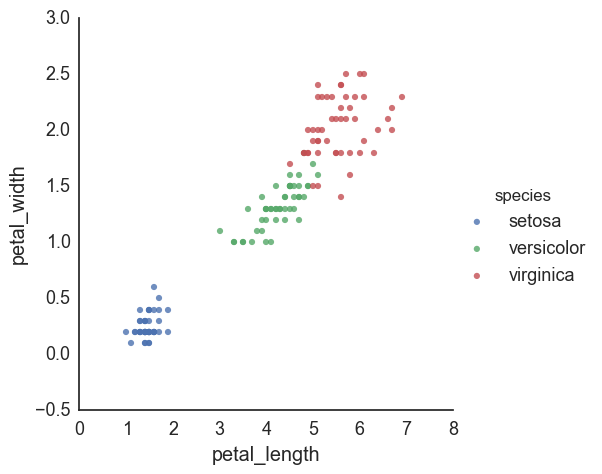

In [24]:
# Step 1: Import the iris dataset and create scatterplot.
# Show only petal_length and petal_width.
df_iris = sns.load_dataset('iris')
sns.lmplot(x='petal_length', y='petal_width', hue='species', 
           fit_reg=False, data=df_iris);

In [25]:
# Step 2: Compute distance matrix. Using petal_length and petal_width only.
# plpw means "petal_length and petal_width"
dist_iris_plpw = spd.squareform(spd.pdist(
        df_iris[['petal_length', 'petal_width']], 
        metric='euclidean'))
dist_iris_plpw.shape

(150, 150)

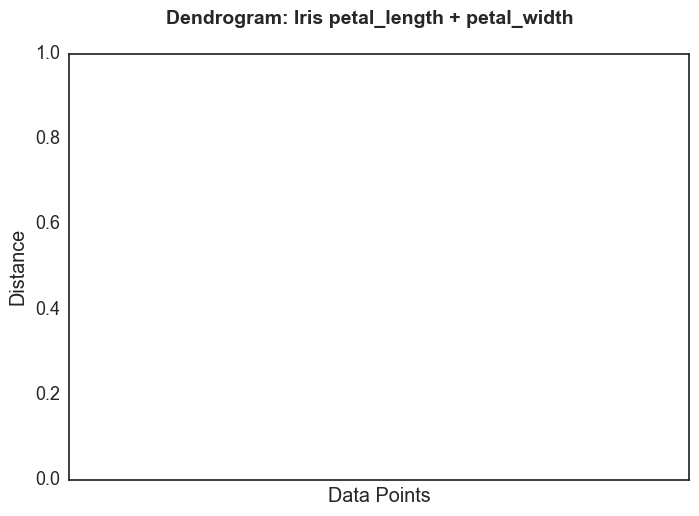

In [26]:
# Step 3: Perform hierarchical clustering

### YOUR CODE HERE
plt.xlabel('Data Points')
plt.xticks([])
plt.ylabel('Distance')
plt.suptitle('Dendrogram: Iris petal_length + petal_width', 
             fontweight='bold', fontsize=14);

In [27]:
# Step 4: Pick a threshold and get the cluster label for each point.
cluster_labels = ### YOUR CODE HERE
df_iris['cluster_label_plpw'] = cluster_labels
df_iris.head()

SyntaxError: invalid syntax (<ipython-input-27-46e6112ca0c9>, line 2)

In [ ]:
# Step 5: Scatterplot comparison: true label vs. cluster label
df_a = df_iris.copy()
df_b = df_iris.copy()
df_a['label_source'] = 'Species'
df_b['label_source'] = 'Cluster Label (PLPW)'
df_a['label'] = df_a['species']
df_b['label'] = df_b['cluster_label_plpw'].apply(lambda x: 'Cluster %d'%x)
df_c = pd.concat((df_a, df_b), axis=0, ignore_index=True)
sns.lmplot(x='petal_length', y='petal_width', col='label_source',
           hue='label', data=df_c, fit_reg=False, size=4);

In [ ]:
# Step 6: Create confusion matrix.
# Each cell in the confusion matrix tells us the number
# of points that had a specific species label (e.g., 'setosa')
# and that had a specific hiearchical-clustering generated label
# (e.g., "1" for cluster 1). Because we have 50 of each species
# in the original data, we'd see 50 setosa in one cluster, 50
# versicolor in another, and 50 virginica in a third. 

# Here's another description of confusion matrices:
# http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

# "Deviations" from this are potentially mistakes
df_iris.pivot_table(index='species', columns='cluster_label_plpw', 
                    aggfunc='size', fill_value=0)

### Try to perform hierarchical clustering on the traits data.

Do you get different groupings if you apply different distance measures?

Are some more stable than others?

Answer worksheet question 4

In [ ]:
### YOUR CODE HERE

# References
- Coursera Jeff Leek's "Data Analysis" Course Notes: https://github.com/herrfz/dataanalysis
- Scikit-learn clustering tutorial: http://scikit-learn.org/stable/modules/clustering.html
- Manning et al. ["Evaluation of Clustering"](http://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html). _Introduction to Information Retrieval_ (2008).